In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import math

In [2]:
op_ar = [1.025]
if_ar = [1]

In [3]:
nl_nuts = gpd.read_file('nl_nuts.shp')

In [4]:
sector = 'C20'

In [5]:
rest = ['allowed', 'restrict']

In [6]:
def output_calculator(op_factor, imp_flex, dis, nl_nuts, string,sector):

    Xdis = pd.read_excel(f'Xdis3_{op_factor}_{imp_flex}_{dis}_mosek_NL41_{string}.xlsx', index_col = [0], header = [1])
    Xdis = Xdis.drop("Index2", axis = 'index')
    
    Xbase = pd.read_excel(f'Xbase_{op_factor}_{imp_flex}_{dis}_mosek.xlsx', index_col = [0], header = [1])
    Xbase = Xbase.drop("Index2", axis = 'index')
    
    X_diff = (Xbase - Xdis)
    
    for m in range(len(nl_nuts)):
        nuts_id = nl_nuts.loc[m,'NUTS_ID']
        output_change =  X_diff.loc[sector,nuts_id].sum()
        nl_nuts.loc[m,'output_change'] = output_change / 365

    return nl_nuts

In [7]:
absbins = [-100, -3, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 3, 1000]

In [8]:
def assign_bands(loss_ss_ci, absbins):
    

    abslabels = np.arange(1,11,1)
    
    color_dict = {
    1: '#03045e' , 
    2: '#0077b6',
    3: '#00b4d8',
    4: '#90e0ef',
    5: '#caf0f8', 
    6: '#fed0bb',
    7: '#fcb9b2',
    8: '#b23a48',
    9: '#8c2f39',
    10: '#461220'
    }
    
    # Adding band columns
    loss_ss_ci['band_absolute'] = pd.cut(loss_ss_ci['output_change'], bins=absbins, labels=abslabels, right=False)

    # Add the color code column
    loss_ss_ci['color_code_abs'] = loss_ss_ci['band_absolute'].map(color_dict)
    return loss_ss_ci

In [9]:
not_allowed = output_calculator(1.025, 1, 0.1, nl_nuts, 'restrict', sector)
not_allowed = assign_bands(not_allowed, absbins)

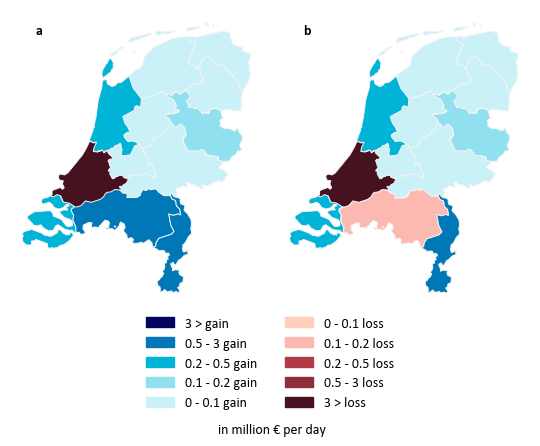

In [15]:
fig = plt.figure(figsize=(5.5, 4.5))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.2])  

axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
ax1, ax2 = axes
label_posx = 0.1
label_posy = 0.95

# Plot allowed datset
allowed = output_calculator(1.025, 1, 0.1, nl_nuts, 'allowed', sector)
allowed = assign_bands(allowed, absbins)

for color in allowed['color_code_abs'].unique():
    subset1 = allowed[allowed['color_code_abs'] == color]
    subset1.plot(ax=ax1, color=color, edgecolor='#f5f3f4', linewidth=0.7)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_axis_off()
ax1.text(label_posx, label_posy , 'a', transform=ax1.transAxes, fontsize=10, fontweight='bold', fontname = 'Calibri', va='top', ha='left')

# Plot not allowed dataset
nallowed = output_calculator(1.025, 1, 0.1, nl_nuts, 'restrict', sector)
nallowed = assign_bands(nallowed, absbins)

for color in nallowed['color_code_abs'].unique():
    subset1 = nallowed[nallowed['color_code_abs'] == color]
    subset1.plot(ax=ax2, color=color, edgecolor='#f5f3f4', linewidth=0.7)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_axis_off()
ax2.text(label_posx, label_posy , 'b', transform=ax2.transAxes, fontsize=10, fontweight='bold', fontname = 'Calibri', va='top', ha='left')

fig_legend = fig.add_subplot(gs[1, :])

color_labels = {
f'{-1*(absbins[1])} > gain ': '#03045e' , 
f'{-1*(absbins[2])} - {-1*(absbins[1])} gain': '#0077b6',
f'{-1*(absbins[3])} - {-1*(absbins[2])} gain': '#00b4d8',
f'{-1*(absbins[4])} - {-1*(absbins[3])} gain': '#90e0ef',
f'{(absbins[5])} - {-1*(absbins[4])} gain': '#caf0f8', 
f'{(absbins[5])} - {(absbins[6])} loss': '#fed0bb',
f'{(absbins[6])} - {(absbins[7])} loss': '#fcb9b2',
f'{(absbins[7])} - {(absbins[8])} loss': '#b23a48',
f'{(absbins[8])} - {(absbins[9])} loss': '#8c2f39',
f'{(absbins[9])} > loss': '#461220'
}


# Create legend handles
legend_handles = [Patch(color=color, label=label) for label, color in color_labels.items()]

# Add the legend to the axis
fig_legend.legend(handles=legend_handles, loc='upper center', ncol= 2,  prop={'size': 10, 'family': 'Calibri'}, frameon=False)

# Remove axis
fig_legend.axis('off')
fig_legend.text(0.4, -1 , 'in million € per day', transform = fig_legend.transAxes, fontsize=10, fontname = 'Calibri', va='top', ha='left')
plt.tight_layout()
plt.savefig(f'spatial_plot.png', dpi=300, bbox_inches='tight')
plt.show()